# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
from copy import deepcopy
import pandas as pd
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices
from src.configs import MODELLED_MARKETS

config = "severe vol and severe growth"
scenario_ = Scenario(config, MODELLED_MARKETS)
print(
    f"Running {scenario_.num_steps} steps with frequency {scenario_.pricepaths.config['freq']}."
)

[INFO][12:36:11][src.sim.scenario]-9132: Fetching wbtc market from subgraph
[INFO][12:36:15][src.sim.scenario]-9132: Market snapshot as 2024-01-16 22:24:59
[INFO][12:36:15][src.sim.scenario]-9132: Bands snapshot as 2024-01-15 19:58:47
[INFO][12:36:15][src.sim.scenario]-9132: Users snapshot as 2024-01-16 23:17:47
[INFO][12:36:15][src.sim.scenario]-9132: Fetching weth market from subgraph
[INFO][12:36:19][src.sim.scenario]-9132: Market snapshot as 2024-01-16 22:24:59
[INFO][12:36:19][src.sim.scenario]-9132: Bands snapshot as 2024-01-15 19:58:47
[INFO][12:36:19][src.sim.scenario]-9132: Users snapshot as 2024-01-16 23:17:47
[INFO][12:36:19][src.sim.scenario]-9132: Fetching sfrxeth market from subgraph
[INFO][12:36:23][src.sim.scenario]-9132: Market snapshot as 2024-01-16 22:24:59
[INFO][12:36:23][src.sim.scenario]-9132: Bands snapshot as 2024-01-15 19:58:47
[INFO][12:36:23][src.sim.scenario]-9132: Users snapshot as 2024-01-16 23:17:47
[INFO][12:36:23][src.sim.scenario]-9132: Fetching wstet

Running 288 steps with frequency 5min.


In [3]:
scenario = deepcopy(scenario_)
scenario.prepare_for_run()

In [4]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)

In [5]:
import cProfile
import pstats

with cProfile.Profile() as pr:
    for sample in scenario.pricepaths:
        # print(sample.timestamp.time())
        scenario.prepare_for_trades(sample)  # update prices/timestamps
        scenario.perform_actions(sample)  # arbitrage, liquidate, update
        processor.update(sample.timestamp, inplace=True)  # collect metrics

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.CUMULATIVE)
stats.print_stats()

         265740464 function calls (265603029 primitive calls) in 104.561 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      288    0.001    0.000   89.541    0.311 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/sim/scenario.py:516(perform_actions)
      288    0.003    0.000   79.211    0.275 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:31(arbitrage)
      840    0.086    0.000   79.066    0.094 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:75(find_best_arbitrage)
    47040    0.086    0.000   78.831    0.002 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:139(optimize)
    39352    0.142    0.000   62.348    0.002 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:271(_optimize_mem)
    34293    0.184    0.000   61.014    0.002 /Users/tncintra/Des

In [6]:
results = processor.process()

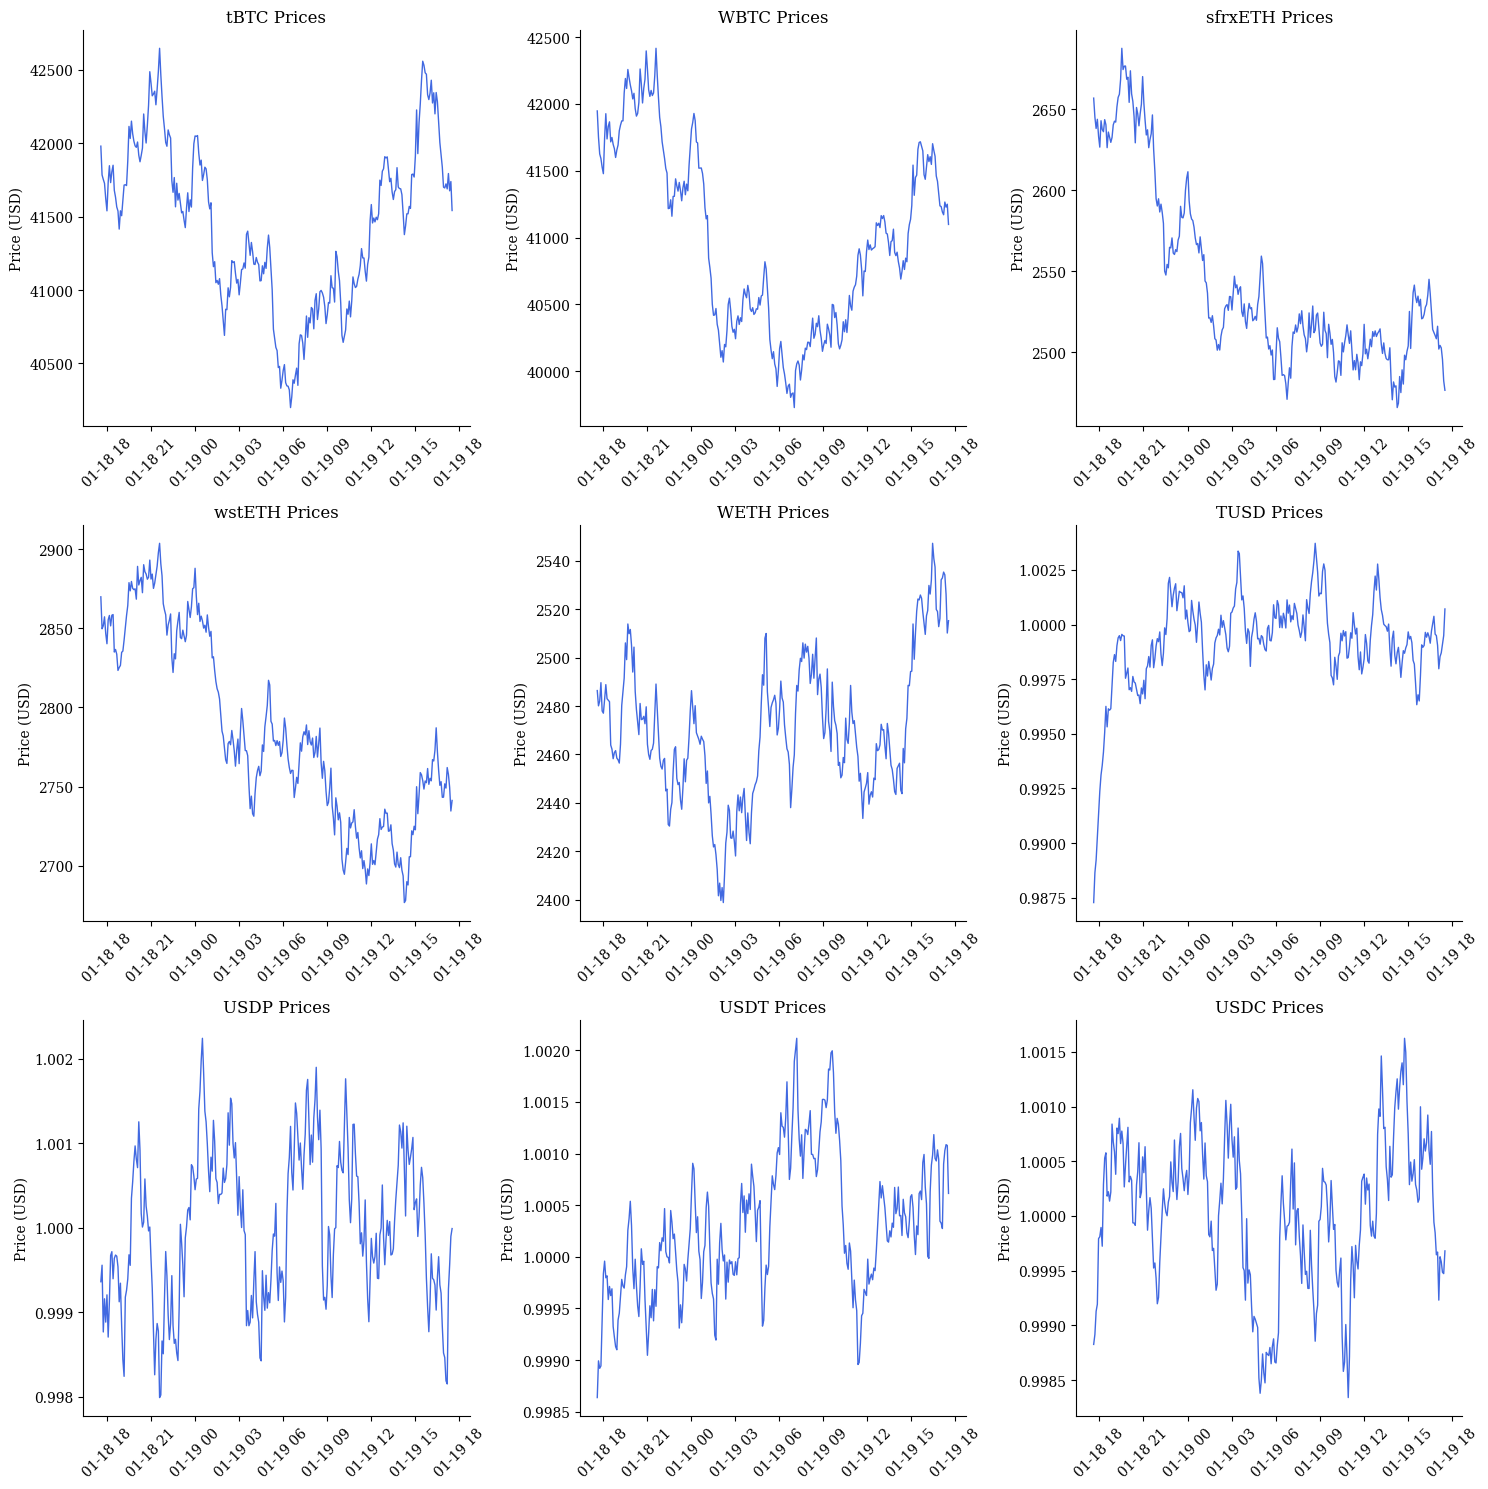

In [7]:
results.plot_prices()

In [8]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,Bad Debt Pct,Bad Debt Pct on Controller Wbtc,Bad Debt Pct on Controller Weth,Bad Debt Pct on Controller Sfrxeth,Bad Debt Pct on Controller Wsteth,System Health,System Health on Controller Wbtc,System Health on Controller Weth,System Health on Controller Sfrxeth,System Health on Controller Wsteth,Borrower Loss Pct,Hard Liquidation Loss Pct,Soft Liquidation Loss Pct,Value Leakage,Keeper Profit,Keeper Count,Keeper Profit on Pk Crvusd/Tusd,Keeper Count on Pk Crvusd/Tusd,Keeper Profit on Pk Crvusd/Usdp,Keeper Count on Pk Crvusd/Usdp,Keeper Profit on Pk Crvusd/Usdc,Keeper Count on Pk Crvusd/Usdc,Keeper Profit on Pk Crvusd/Usdt,Keeper Count on Pk Crvusd/Usdt,Liquidator Profit,Liquidator Count,Liquidator Profit on Controller Wbtc,Liquidator Count on Controller Wbtc,Liquidator Profit on Controller Weth,Liquidator Count on Controller Weth,Liquidator Profit on Controller Sfrxeth,Liquidator Count on Controller Sfrxeth,Liquidator Profit on Controller Wsteth,Liquidator Count on Controller Wsteth,Arbitrageur Profit,Arbitrageur Count,Aggregator Price,Stableswap Crvusd_Tusd Price,Stableswap Crvusd_Usdp Price,Stableswap Crvusd_Usdc Price,Stableswap Crvusd_Usdt Price,Debt Liquidated Pct,Debt Liquidated Pct on Controller Wbtc,Debt Liquidated Pct on Controller Weth,Debt Liquidated Pct on Controller Sfrxeth,Debt Liquidated Pct on Controller Wsteth,PK Debt,Pk Crvusd/Tusd Debt,Pk Crvusd/Usdp Debt,Pk Crvusd/Usdc Debt,Pk Crvusd/Usdt Debt,Total crvUSD Liquidity,Stableswap Crvusd_Tusd crvUSD Liquidity,Stableswap Crvusd_Usdp crvUSD Liquidity,Stableswap Crvusd_Usdc crvUSD Liquidity,Stableswap Crvusd_Usdt crvUSD Liquidity,Total Debt,Controller Wbtc Total Debt,Controller Weth Total Debt,Controller Sfrxeth Total Debt,Controller Wsteth Total Debt,Llamma Wbtc Price,Llamma Wbtc Oracle Price,Llamma Weth Price,Llamma Weth Oracle Price,Llamma Sfrxeth Price,Llamma Sfrxeth Oracle Price,Llamma Wsteth Price,Llamma Wsteth Oracle Price
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-19 17:11:28,0.0,0.0,0.0,0.0,0.0,1.450795,1.195270,1.106200,0.979538,1.835387,0.156988,0.108651,0.048337,176736.137964,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,118983.780955,4,115501.993228,2,727.249008,1,0.0,0,2754.538719,1,57752.357009,541,0.999132,0.999780,1.000657,0.999141,0.999069,1.48683,4.27403,0.073184,0.0,0.080484,0.0,0.0,0.0,0.0,0.0,4.441649e+07,2.982330e+06,1.717568e+06,2.131217e+07,1.840443e+07,1.097508e+08,3.597083e+07,1.456659e+07,1.000414e+07,4.920929e+07,40928.187712,41159.369438,2693.236321,2534.688372,2652.166262,2503.451588,2782.683378,2761.291826
2024-01-19 17:16:28,0.0,0.0,0.0,0.0,0.0,1.450077,1.200510,1.105109,0.978170,1.830558,0.156988,0.108651,0.048337,176797.544685,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,118983.780955,4,115501.993228,2,727.249008,1,0.0,0,2754.538719,1,57813.763730,544,0.999142,0.999982,1.000351,0.999209,0.998985,1.48683,4.27403,0.073184,0.0,0.080484,0.0,0.0,0.0,0.0,0.0,4.441648e+07,2.839979e+06,1.859912e+06,2.106991e+07,1.864668e+07,1.097510e+08,3.597087e+07,1.456661e+07,1.000415e+07,4.920936e+07,41206.665103,41252.586396,2689.202096,2533.423942,2646.994966,2501.825860,2769.138287,2756.788231
2024-01-19 17:21:28,0.0,0.0,0.0,0.0,0.0,1.444075,1.198431,1.098252,0.972242,1.821926,0.156988,0.108651,0.048337,176823.540627,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,118983.780955,4,115501.993228,2,727.249008,1,0.0,0,2754.538719,1,57839.759672,546,0.999149,0.999982,1.000351,0.999274,0.998897,1.48683,4.27403,0.073184,0.0,0.080484,0.0,0.0,0.0,0.0,0.0,4.441646e+07,2.839979e+06,1.859912e+06,2.082763e+07,1.888895e+07,1.097511e+08,3.597091e+07,1.456662e+07,1.000417e+07,4.920943e+07,41096.067803,41215.658556,2663.916597,2525.460440,2624.659224,2494.771479,2745.031212,2748.734226
2024-01-19 17:26:28,0.0,0.0,0.0,0.0,0.0,1.434505,1.199700,1.084512,0.961145,1.805977,0.157001,0.108651,0.048349,176869.693816,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,118983.780955,4,115501.993228,2,727.249008,1,0.0,0,2754.538719,1,57885.912861,549,0.999159,0.999982,1.000021,0.999319,0.998897,1.486

<Axes: xlabel='timestamp'>

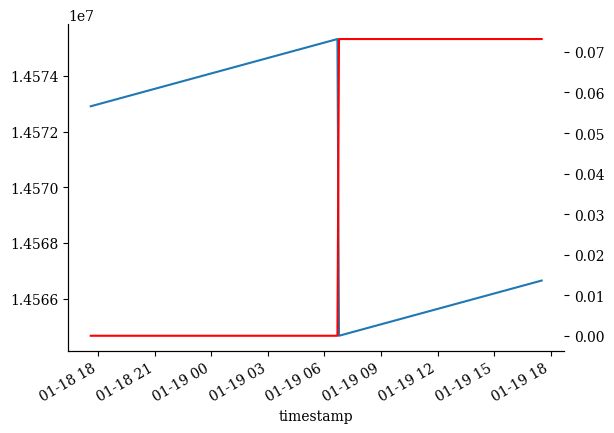

In [9]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax2 = ax.twinx()
df["Controller Weth Total Debt"].plot(ax=ax, label="Total Debt")
df["Debt Liquidated Pct on Controller Weth"].plot(
    ax=ax2, label="Debt Liquidated Pct", color="red"
)

In [10]:
controllers = {c.address: c for c in scenario.controllers}

In [11]:
# Make sure that most of the change in controller debt is due to
# liquidated debt. Some of it won't be due to interest accrual.
for address, amount in scenario.liquidator.debt_repaid.items():
    controller = controllers[address]
    initial_debt = processor.initial_debts[address]
    final_debt = controller.total_debt() / 1e18
    # final_debt = controller._total_debt.initial_debt / 1e18
    print(f"Controller: {controller.AMM.name}")
    print(f"Debt repaid: {amount}")
    print(
        f"Collateral liquidated: {scenario.liquidator.collateral_liquidated[address]}"
    )
    print(f"As percentage: {amount / initial_debt * 100:.2f}%")
    print(f"Initial Debt: {initial_debt:,.0f}")
    print(f"Final Debt: {final_debt:,.0f}")
    print(
        f"Pct Change in Debt: {(final_debt - initial_debt) / initial_debt * 100:.2f}%"
    )
    print()

Controller: Curve.fi Stablecoin WBTC
Debt repaid: 1605534.1306170907
Collateral liquidated: 16.15605699
As percentage: 4.27%
Initial Debt: 37,564,874
Final Debt: 35,970,994
Pct Change in Debt: -4.24%

Controller: Curve.fi Stablecoin WETH
Debt repaid: 10665.037144061882
Collateral liquidated: 2.8855331292154065
As percentage: 0.07%
Initial Debt: 14,572,906
Final Debt: 14,566,651
Pct Change in Debt: -0.04%

Controller: Curve.fi Stablecoin sfrxETH
Debt repaid: 0.0
Collateral liquidated: 0
As percentage: 0.00%
Initial Debt: 10,000,000
Final Debt: 10,004,199
Pct Change in Debt: 0.04%

Controller: Curve.fi Stablecoin wstETH
Debt repaid: 39620.94298685569
Collateral liquidated: 8.541033968003827
As percentage: 0.08%
Initial Debt: 49,228,053
Final Debt: 49,209,580
Pct Change in Debt: -0.04%



In [13]:
results.metric_map

{'BadDebtMetric': 0,
 'SystemHealthMetric': 1,
 'BorrowerLossMetric': 2,
 'ValueLeakageMetric': 3,
 'PegStrengthMetric': 4,
 'LiquidationsMetric': 5,
 'PegKeeperMetric': 6,
 'LiquidityMetric': 7,
 'MiscMetric': 8}

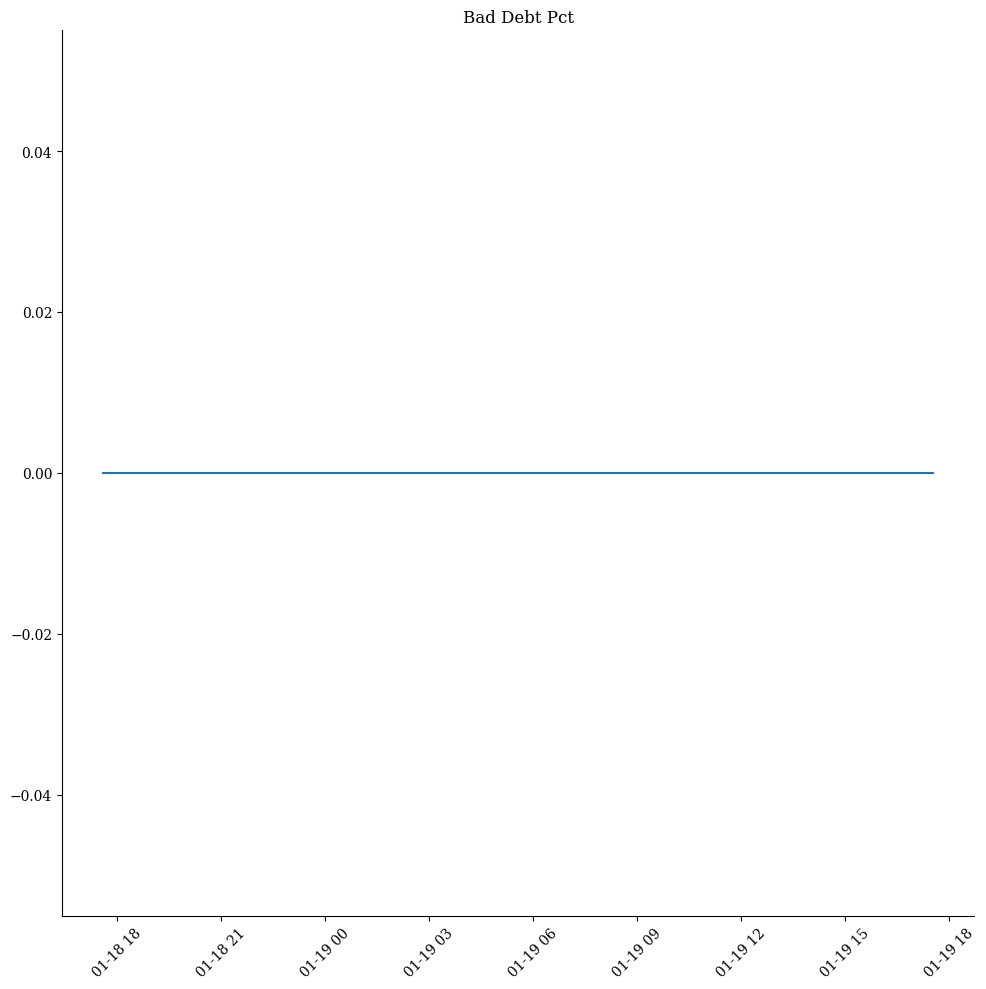

<Axes: title={'center': 'Bad Debt Pct'}>

In [14]:
results.plot_metric(0, show=True)

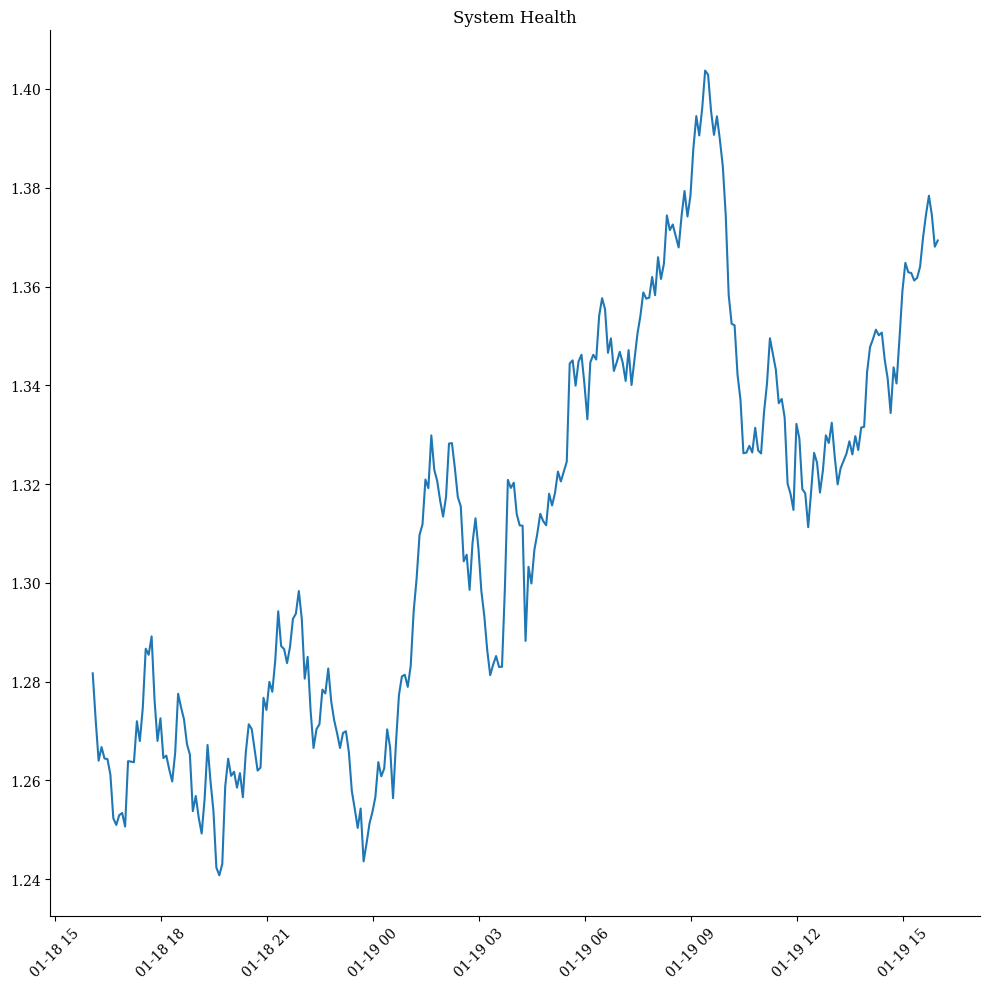

<Axes: title={'center': 'System Health'}>

In [ ]:
results.plot_metric(1, show=True)

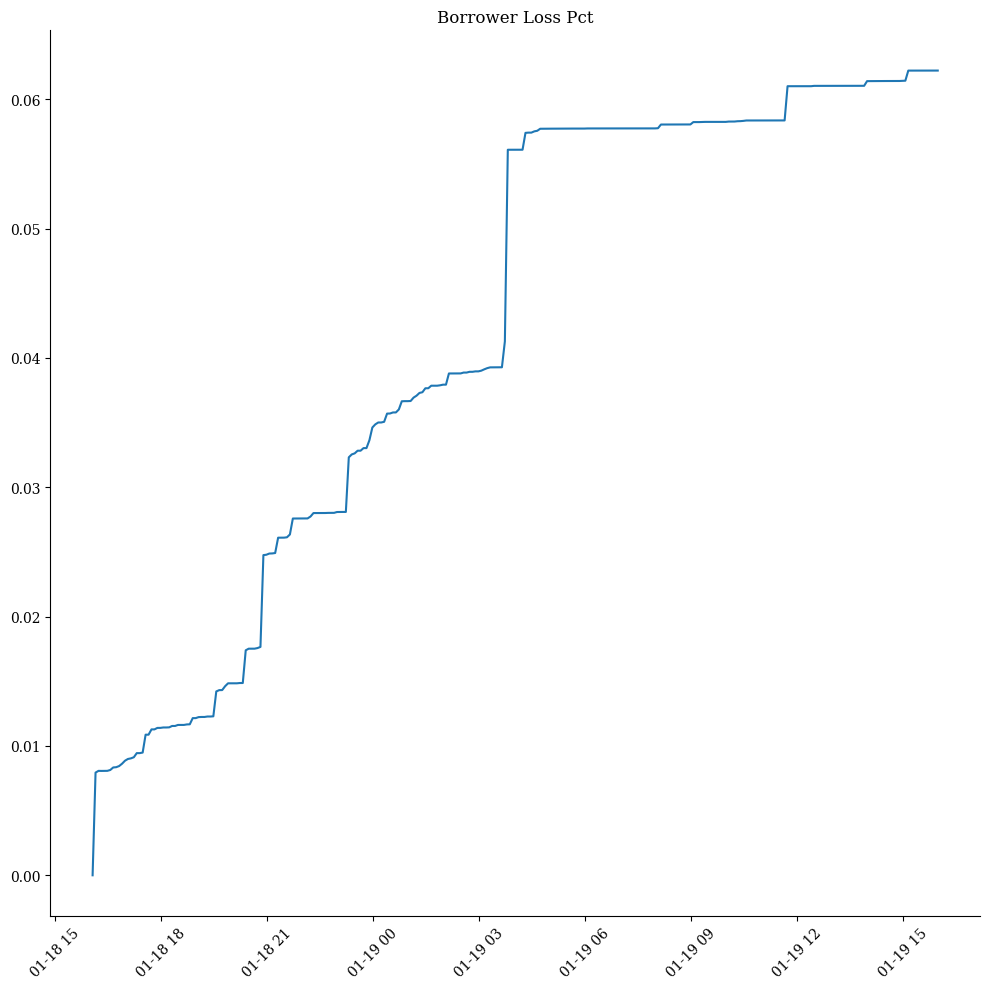

<Axes: title={'center': 'Borrower Loss Pct'}>

In [ ]:
results.plot_metric(2, show=True)

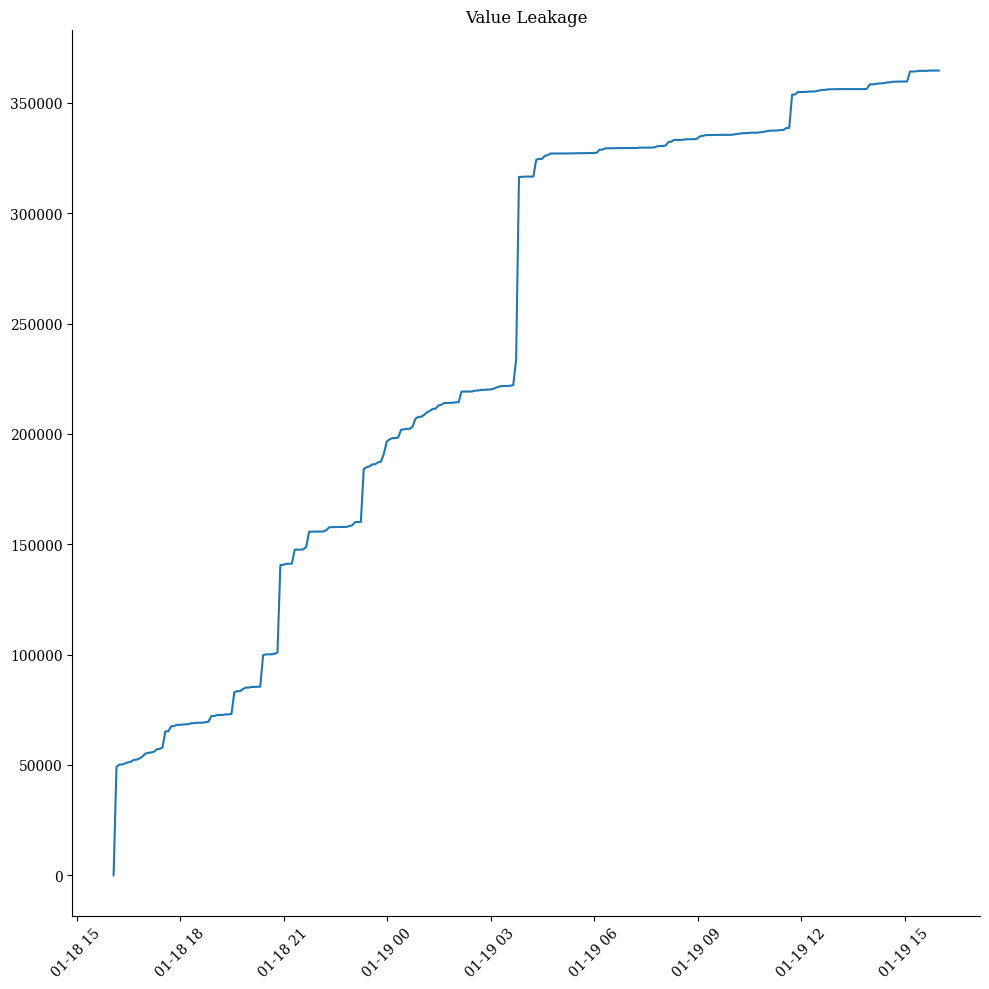

<Axes: title={'center': 'Value Leakage'}>

In [ ]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

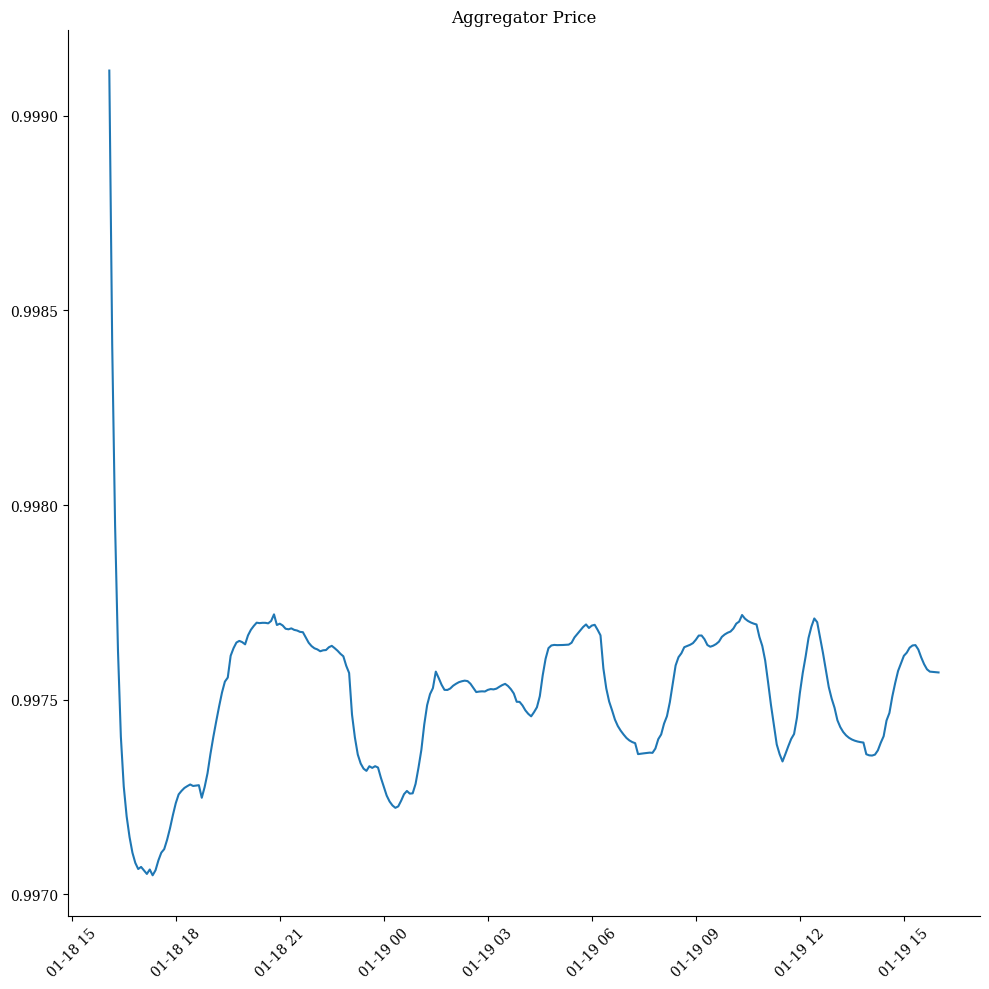

<Axes: title={'center': 'Aggregator Price'}>

In [ ]:
results.plot_metric(4, show=True)

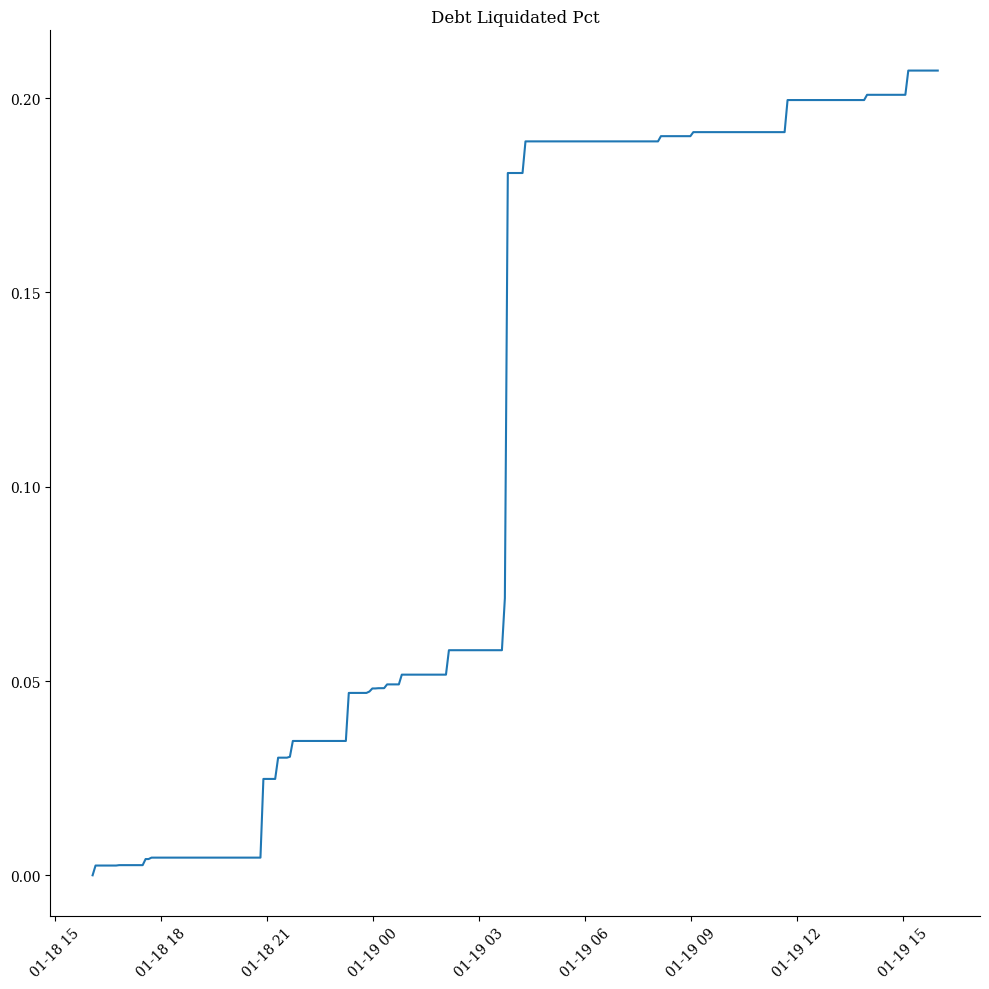

<Axes: title={'center': 'Debt Liquidated Pct'}>

In [ ]:
results.plot_metric(5, show=True)

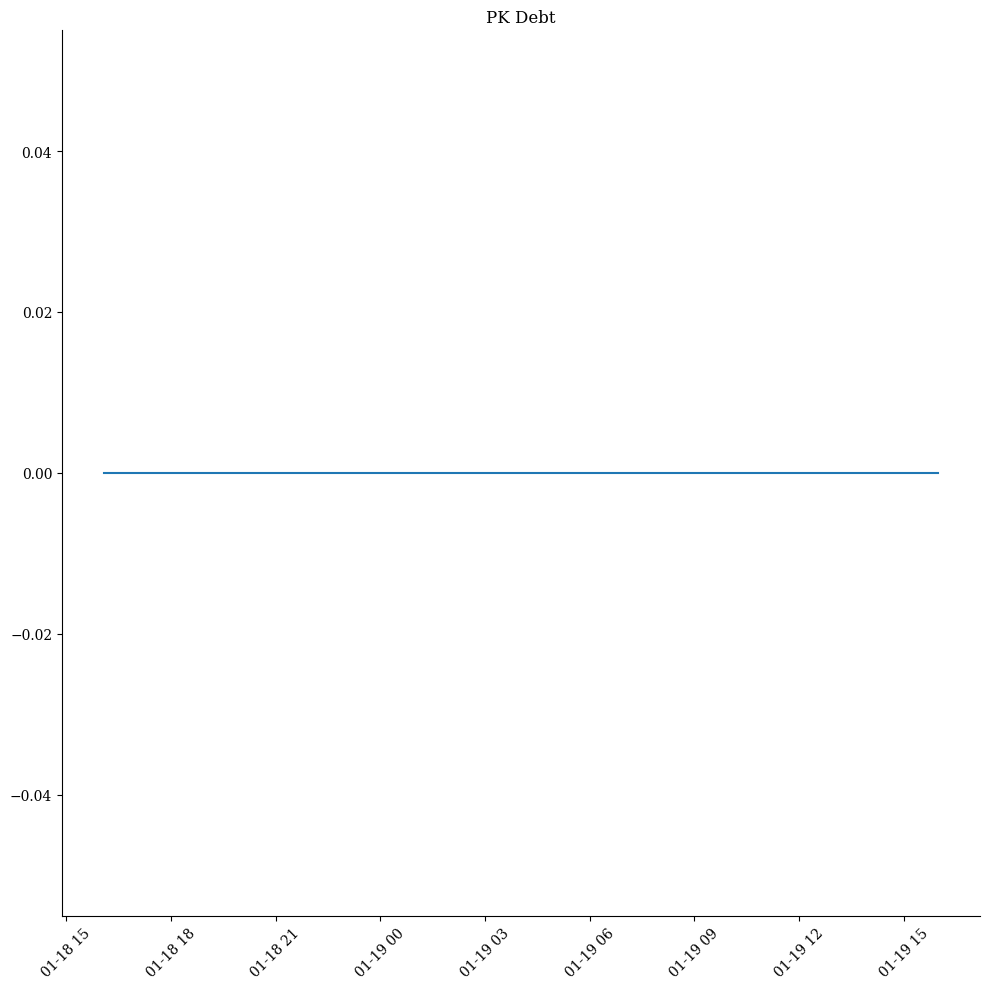

<Axes: title={'center': 'PK Debt'}>

In [ ]:
results.plot_metric(6, show=True)

In [ ]:
summary = results.summary.T
summary.columns = ["value"]
summary

,value
Bad Debt Pct Max,0.000002
Bad Debt Pct On Controller Wbtc Max,0.000000
Bad Debt Pct On Controller Weth Max,0.000007
Bad Debt Pct On Controller Sfrxeth Max,0.000000
Bad Debt Pct On Controller Wsteth Max,0.000000
...,...
Llamma Weth Oracle Price Mean,2587.487766
Llamma Sfrxeth Price Mean,3564.439364
Llamma Sfrxeth Oracle Price Mean,2709.452068
Llamma Wsteth Price Mean,2976.123763
